# Vision Transformer

## Imports

In [ ]:
import cv2
import time
import math
import torch
import seaborn
import torchvision
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.autoaugment import AutoAugmentPolicy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## Dataset Class

In [ ]:
class CIFAR10PDataset(Dataset):
    def __init__(self, train=True, patch_size=4, transform=None):
        self.data = datasets.CIFAR10(root="./data", train=train, download=True)
        self.patch_size = patch_size
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform is not None:
            img = self.transform(img)

        # Creating the image into patches
        C, H, W = img.shape
        patches = img.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.permute(1, 2, 0, 3, 4).contiguous()
        patches = patches.view(-1, C * self.patch_size * self.patch_size) # Flatten each patch into the vector of size patch_size x patch_size x n_channels
        
        return patches, label

## ViT Class

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        # LN 1
        self.ln1 = nn.LayerNorm(emb_dim)

        # MSA
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads
        self.qkv_proj = nn.Linear(emb_dim, emb_dim * 3)
        self.out_proj = nn.Linear(emb_dim, emb_dim)
        self.dropout1 = nn.Dropout(dropout)

        # LN 2
        self.ln2 = nn.LayerNorm(emb_dim)

        # MLP
        hidden_dim = int(emb_dim * mlp_ratio)
        self.fc1 = nn.Linear(emb_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, emb_dim)
        self.act = nn.GELU()
        self.dropout2 = nn.Dropout(dropout)

        # Attention weights
        self.attn_weights = None

    def forward(self, x):
        # ================================= LN 1 ==========================================
        x = self.ln1(x)
        
        # ================================= MSA ==========================================
        B, N, D = x.shape
        qkv = self.qkv_proj(x)  # (B, N, 3*D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        Q, K, V = qkv[0], qkv[1], qkv[2]  # Each: (B, heads, N, head_dim)
        # Scaled dot-product attention
        scores = (Q @ K.transpose(-2, -1)) / math.sqrt(self.head_dim)  # (B, heads, N, N)
        attn = torch.softmax(scores, dim=-1)
        self.attn_weights = attn # saving the attention weights for visualisation
        attn = self.dropout1(attn)
        out = attn @ V  # (B, heads, N, head_dim)
        out = out.transpose(1, 2).contiguous().view(B, N, D)  # (B, N, D)
        x1 = self.out_proj(out)
        
        # ============================== Skip conn 1 ======================================
        x = x + x1
        
        # ================================= LN 2 ==========================================
        x = self.ln2(x)
        
        # ================================= MLP ==========================================
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x2 = self.dropout2(x)
        
        # ============================== Skip conn 2 ======================================
        x = x1 + x2
        
        # ================================================================================
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, depth, emb_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(emb_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.attn_weights = []

    def forward(self, x):
        self.attn_weights = []
        for layer in self.layers:
            x = layer(x)
            self.attn_weights.append(layer.attn_weights)
        return x

class ViT(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout, positional_embeddings = "1d"):
        super().__init__()
        self.positional_embeddings = positional_embeddings
        self.emb_dim = emb_dim

        # Linear Embedding of patches
        self.patch_embed = nn.Linear(in_features=patch_size * patch_size * in_channels, out_features=emb_dim, bias=True)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim).to(device))
        
        num_patches = (img_size // patch_size) ** 2
        num_patches_per_side = img_size // patch_size
        
        if positional_embeddings is None:
            pass
        elif positional_embeddings == "1d":
            self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, emb_dim).to(device))
        elif positional_embeddings == "2d":
             self.pos_embed_2d = nn.Parameter(
                torch.randn(1, num_patches_per_side, num_patches_per_side, emb_dim).to(device)
            )
        elif positional_embeddings == "sinusoidal":
            self.register_buffer(
                'pos_embed_sinusoidal',
                self.get_2d_sinusoidal_pos_embed(emb_dim, num_patches_per_side).unsqueeze(0)
            ) 
        self.dropout = nn.Dropout(dropout)
        self.transformer = TransformerEncoder(depth, emb_dim, num_heads, mlp_ratio, dropout)
        self.head = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        B, N, _ = x.shape
        # ============================ Embed Patches =====================================
        x = self.patch_embed(x)  # -> (B, N, emb_dim)
        
        # ============================= Prepend CLS =====================================
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, emb_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1 + N, emb_dim)
        
        # ============================ Add Pos Embed =====================================
        if self.positional_embeddings is None:
            pass
        elif self.positional_embeddings == "1d":
            x += self.pos_embed
        elif self.positional_embeddings == "2d":
            pos_embed = self.pos_embed_2d.view(1, -1, self.emb_dim)
            pos_embed = torch.cat([torch.zeros(1, 1, self.emb_dim).to(device), pos_embed], dim=1)
            x += pos_embed
        elif self.positional_embeddings == "sinusoidal":
            pos_embed = torch.cat([torch.zeros(1, 1, self.emb_dim).to(device), self.pos_embed_sinusoidal], dim=1)
            x += pos_embed
            
        x = self.dropout(x)
       
        # ========================== Transformer Encoder =================================
        x = self.transformer(x)
        
        # ========================== Classification Head =================================
        cls_out = x[:, 0]
        out = self.head(cls_out)
        
        # ================================================================================
        return out

    def get_2d_sinusoidal_pos_embed(self, embed_dim, grid_size):
        def get_1d_sin_cos_pos_embed(embed_dim, pos):
            dim_half = embed_dim // 2
            omega = torch.arange(dim_half, dtype=torch.float32) / dim_half
            omega = 1.0 / (10000 ** omega)
            out = torch.einsum('p,d->pd', pos, omega)
            emb = torch.cat([torch.sin(out), torch.cos(out)], dim=-1)
            return emb
    
        grid_h = torch.arange(grid_size, dtype=torch.float32)
        grid_w = torch.arange(grid_size, dtype=torch.float32)
        grid = torch.meshgrid(grid_h, grid_w, indexing='ij')
        grid = torch.stack(grid, dim=-1).reshape(-1, 2)  # [N, 2]
    
        pos_emb_h = get_1d_sin_cos_pos_embed(embed_dim // 2, grid[:, 0])
        pos_emb_w = get_1d_sin_cos_pos_embed(embed_dim // 2, grid[:, 1])
        return torch.cat([pos_emb_h, pos_emb_w], dim=1)  # [N, D]

### Hyperparameters

In [ ]:
# Fixed vars
img_size    = 32
in_channels = 3
num_classes = 10
batch_size  = 32

# Tuneable hyperparameters
emb_dim    = 128
patch_size = 4
depth      = 4
num_heads  = 4
lr         = 0.001
mlp_ratio  = 2.0
dropout    = 0.2
epochs     = 50

### Functions for training, evaluating and plotting

In [ ]:
def train_model(model, lr, epochs, loader, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accuracies = [], []

    start_time = time.time()
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
    
        for x, y in loader:
            x, y = x.to(device), y.to(device)
    
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
    
            epoch_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    
        train_loss = epoch_loss / total
        train_acc = (correct / total) * 100
    
        print(f"Train Loss: {round(train_loss, 4)} | Train Acc: {round(train_acc, 2)}%")
    
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
    end_time = time.time()
    print(f"Time taken to train: {round(end_time - start_time, 4)} seconds")

    return train_losses, train_accuracies

def plot_loss_and_acc(losses_arr, accuracies_arr):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].plot(losses_arr, label='Train Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss Curve')
    axes[0].grid()
    axes[0].legend()
    
    axes[1].plot(accuracies_arr, label='Train Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training Accuracy Curve')
    axes[1].grid()
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

def evaluate(model, loader):
    criterion = nn.CrossEntropyLoss()
    
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return total_loss / total, correct / total

### Dataloaders and transforms

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset_initial = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform)
test_dataset_initial = CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform)

train_loader_initial = DataLoader(train_dataset_initial, batch_size=batch_size, shuffle=True)
test_loader_initial = DataLoader(test_dataset_initial, batch_size=batch_size, shuffle=False)

### Define model

In [ ]:
model_initial = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)

### Train model

In [2]:
train_losses_initial, train_accuracies_initial = train_model(model_initial, lr, epochs, train_loader_initial, device)

Epoch 1/50
Train Loss: 1.6349 | Train Acc: 40.67%

Epoch 2/50
Train Loss: 1.3442 | Train Acc: 51.32%

Epoch 3/50
Train Loss: 1.2344 | Train Acc: 55.59%

Epoch 4/50
Train Loss: 1.1551 | Train Acc: 58.46%

Epoch 5/50
Train Loss: 1.0917 | Train Acc: 60.86%

Epoch 6/50
Train Loss: 1.0372 | Train Acc: 63.08%

Epoch 7/50
Train Loss: 0.9928 | Train Acc: 64.57%

Epoch 8/50
Train Loss: 0.9509 | Train Acc: 65.95%

Epoch 9/50
Train Loss: 0.9134 | Train Acc: 67.36%

Epoch 10/50
Train Loss: 0.8752 | Train Acc: 68.76%

Epoch 11/50
Train Loss: 0.8463 | Train Acc: 69.81%

Epoch 12/50
Train Loss: 0.8099 | Train Acc: 71.30%

Epoch 13/50
Train Loss: 0.7905 | Train Acc: 72.01%

Epoch 14/50
Train Loss: 0.7561 | Train Acc: 73.04%

Epoch 15/50
Train Loss: 0.7339 | Train Acc: 73.80%

Epoch 16/50
Train Loss: 0.7116 | Train Acc: 74.56%

Epoch 17/50
Train Loss: 0.6880 | Train Acc: 75.47%

Epoch 18/50
Train Loss: 0.6630 | Train Acc: 76.35%

Epoch 19/50
Train Loss: 0.6459 | Train Acc: 76.89%

Epoch 20/50
Train Los

### Plotting loss and accuracy graphs

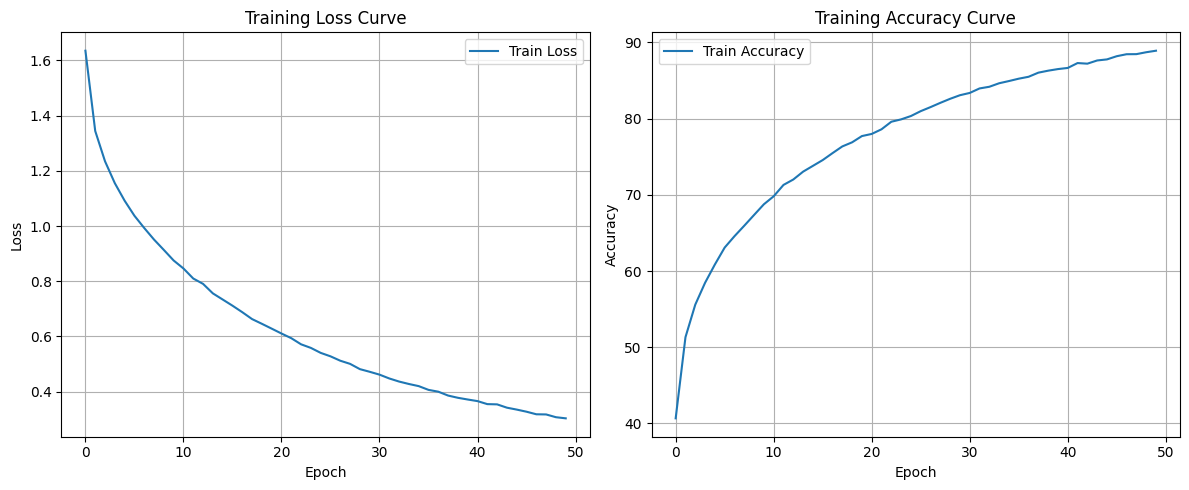

In [5]:
plot_loss_and_acc(train_losses_initial, train_accuracies_initial)

### Evaluating the model

In [1]:
test_loss_initial, test_acc_initial = evaluate(model_initial, test_loader_initial)
print(f"\nFinal Test Loss: {round(test_loss_initial, 4)} | Final Test Accuracy: {round(test_acc_initial * 100, 2)}%")


Final Test Loss: 1.2343 | Final Test Accuracy: 68.92%


## Patch Size Variation

### Patch Size 2

In [6]:
patch_size = 2

train_dataset_ps2 = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform)
test_dataset_ps2 = CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform)

train_loader_ps2 = DataLoader(train_dataset_ps2, batch_size=batch_size, shuffle=True)
test_loader_ps2 = DataLoader(test_dataset_ps2, batch_size=batch_size, shuffle=False)

model_ps2 = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_ps2, train_accuracies_ps2 = train_model(model_ps2, lr, epochs, train_loader_ps2, device)

Epoch 1/50
Train Loss: 1.6958 | Train Acc: 37.63%

Epoch 2/50
Train Loss: 1.4159 | Train Acc: 48.55%

Epoch 3/50
Train Loss: 1.3090 | Train Acc: 52.53%

Epoch 4/50
Train Loss: 1.2402 | Train Acc: 54.83%

Epoch 5/50
Train Loss: 1.1791 | Train Acc: 57.44%

Epoch 6/50
Train Loss: 1.1291 | Train Acc: 59.22%

Epoch 7/50
Train Loss: 1.0798 | Train Acc: 61.16%

Epoch 8/50
Train Loss: 1.0423 | Train Acc: 62.47%

Epoch 9/50
Train Loss: 1.0060 | Train Acc: 63.71%

Epoch 10/50
Train Loss: 0.9693 | Train Acc: 65.23%

Epoch 11/50
Train Loss: 0.9357 | Train Acc: 66.20%

Epoch 12/50
Train Loss: 0.9069 | Train Acc: 67.47%

Epoch 13/50
Train Loss: 0.8839 | Train Acc: 68.28%

Epoch 14/50
Train Loss: 0.8591 | Train Acc: 69.11%

Epoch 15/50
Train Loss: 0.8330 | Train Acc: 70.19%

Epoch 16/50
Train Loss: 0.8077 | Train Acc: 71.05%

Epoch 17/50
Train Loss: 0.7838 | Train Acc: 71.93%

Epoch 18/50
Train Loss: 0.7636 | Train Acc: 72.61%

Epoch 19/50
Train Loss: 0.7419 | Train Acc: 73.39%

Epoch 20/50
Train Los

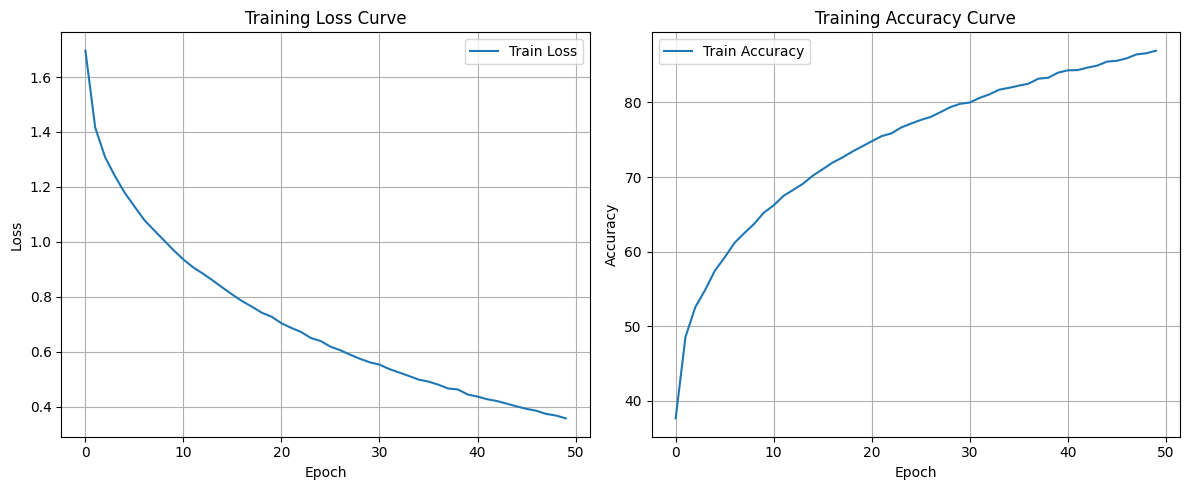


Final Test Loss: 1.2947 | Final Test Accuracy: 66.64%


In [7]:
plot_loss_and_acc(train_losses_ps2, train_accuracies_ps2)
test_loss_ps2, test_acc_ps2 = evaluate(model_ps2, test_loader_ps2)
print(f"\nFinal Test Loss: {round(test_loss_ps2, 4)} | Final Test Accuracy: {round(test_acc_ps2 * 100, 2)}%")

### Patch Size 4

> As trained above (Initial Model)

### Patch Size 8

In [8]:
patch_size = 8

train_dataset_ps8 = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform)
test_dataset_ps8 = CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform)

train_loader_ps8 = DataLoader(train_dataset_ps8, batch_size=batch_size, shuffle=True)
test_loader_ps8 = DataLoader(test_dataset_ps8, batch_size=batch_size, shuffle=False)

model_ps8 = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_ps8, train_accuracies_ps8 = train_model(model_ps8, lr, epochs, train_loader_ps8, device)

Epoch 1/50
Train Loss: 1.6398 | Train Acc: 40.35%

Epoch 2/50
Train Loss: 1.3915 | Train Acc: 49.91%

Epoch 3/50
Train Loss: 1.2980 | Train Acc: 53.46%

Epoch 4/50
Train Loss: 1.2283 | Train Acc: 55.91%

Epoch 5/50
Train Loss: 1.1694 | Train Acc: 58.20%

Epoch 6/50
Train Loss: 1.1238 | Train Acc: 59.46%

Epoch 7/50
Train Loss: 1.0855 | Train Acc: 61.33%

Epoch 8/50
Train Loss: 1.0407 | Train Acc: 62.79%

Epoch 9/50
Train Loss: 1.0012 | Train Acc: 64.12%

Epoch 10/50
Train Loss: 0.9658 | Train Acc: 65.49%

Epoch 11/50
Train Loss: 0.9314 | Train Acc: 66.66%

Epoch 12/50
Train Loss: 0.8963 | Train Acc: 68.06%

Epoch 13/50
Train Loss: 0.8718 | Train Acc: 68.84%

Epoch 14/50
Train Loss: 0.8403 | Train Acc: 70.01%

Epoch 15/50
Train Loss: 0.8119 | Train Acc: 71.03%

Epoch 16/50
Train Loss: 0.7869 | Train Acc: 71.72%

Epoch 17/50
Train Loss: 0.7597 | Train Acc: 72.88%

Epoch 18/50
Train Loss: 0.7379 | Train Acc: 73.55%

Epoch 19/50
Train Loss: 0.7124 | Train Acc: 74.42%

Epoch 20/50
Train Los

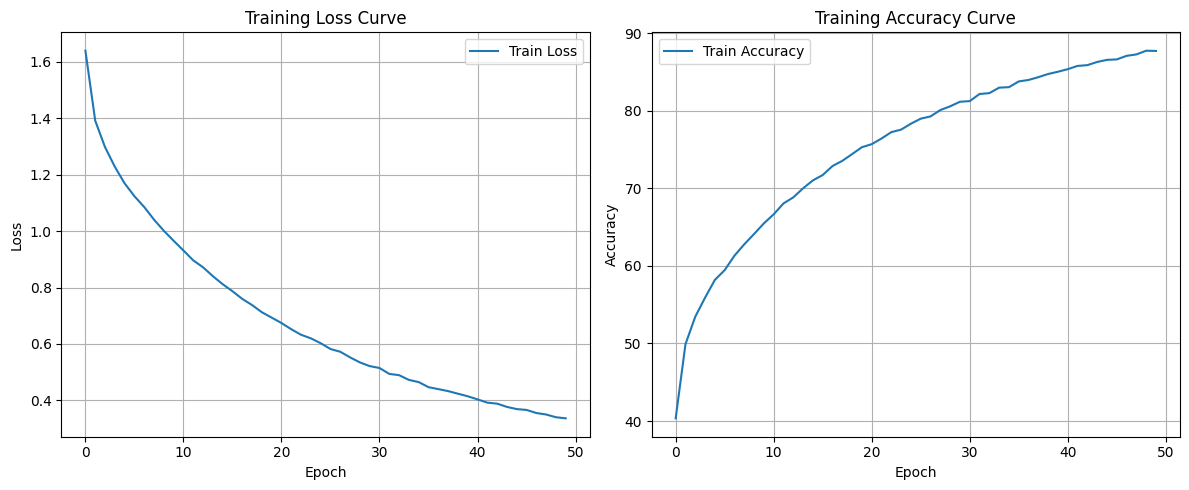


Final Test Loss: 1.4991 | Final Test Accuracy: 63.5%


In [9]:
plot_loss_and_acc(train_losses_ps8, train_accuracies_ps8)
test_loss_ps8, test_acc_ps8 = evaluate(model_ps8, test_loader_ps8)
print(f"\nFinal Test Loss: {round(test_loss_ps8, 4)} | Final Test Accuracy: {round(test_acc_ps8 * 100, 2)}%")

## ViT Performance on CIFAR10 with Different Patch Sizes

### Results:
Below is a comparison of the results for different patch sizes:

<table border="1" cellpadding="5">
  <thead>
    <tr>
      <th>Patch Size</th>
      <th>Train Loss</th>
      <th>Train Accuracy (%)</th>
      <th>Test Loss</th>
      <th>Test Accuracy (%)</th>
      <th>Training Time (seconds)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2</td>
      <td>0.3574</td>
      <td>86.94</td>
      <td>1.2947</td>
      <td>66.64</td>
      <td>1974.563</td>
    </tr>
    <tr>
      <td>4</td>
      <td>0.3035</td>
      <td>88.91</td>
      <td>1.2343</td>
      <td>68.92</td>
      <td>1289.707</td>
    </tr>
    <tr>
      <td>8</td>
      <td>0.3361</td>
      <td>87.72</td>
      <td>1.4991</td>
      <td>63.50</td>
      <td>874.578</td>
    </tr>
  </tbody>
</table>

### Conclusion:
Smaller patch sizes provide finer details but capture a smaller context, which can lead to overfitting and longer training times due to the larger number of patches. On the other hand, larger patch sizes capture broader context but result in very coarse representations, losing fine-grained details and leading to poorer generalization on the test set. The optimal patch size strikes a balance between detail and context, with medium-sized patches offering the best trade-off.

## Hyperparameter tuning

In [ ]:
# Parameters constant throughtout the hyper param tuning section
patch_size = 4

train_dataset_param_tuning = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform)
test_dataset_param_tuning= CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform)

train_loader_param_tuning = DataLoader(train_dataset_param_tuning, batch_size=batch_size, shuffle=True)
test_loader_param_tuning = DataLoader(test_dataset_param_tuning, batch_size=batch_size, shuffle=False)

### Hyperparameter 1

In [10]:
# Tuneable hyperparameters
emb_dim    = 92
depth      = 4
num_heads  = 2
mlp_ratio  = 2.0
dropout    = 0.1

model_emb_dim = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_emb_dim, train_accuracies_emb_dim = train_model(model_emb_dim, lr, epochs, train_loader_param_tuning, device)

Epoch 1/50
Train Loss: 1.6538 | Train Acc: 39.59%

Epoch 2/50
Train Loss: 1.3761 | Train Acc: 50.29%

Epoch 3/50
Train Loss: 1.2740 | Train Acc: 53.88%

Epoch 4/50
Train Loss: 1.2089 | Train Acc: 56.44%

Epoch 5/50
Train Loss: 1.1446 | Train Acc: 58.68%

Epoch 6/50
Train Loss: 1.0926 | Train Acc: 60.77%

Epoch 7/50
Train Loss: 1.0434 | Train Acc: 62.77%

Epoch 8/50
Train Loss: 1.0043 | Train Acc: 63.97%

Epoch 9/50
Train Loss: 0.9658 | Train Acc: 65.36%

Epoch 10/50
Train Loss: 0.9284 | Train Acc: 67.07%

Epoch 11/50
Train Loss: 0.8950 | Train Acc: 67.83%

Epoch 12/50
Train Loss: 0.8662 | Train Acc: 69.04%

Epoch 13/50
Train Loss: 0.8390 | Train Acc: 69.82%

Epoch 14/50
Train Loss: 0.8152 | Train Acc: 70.65%

Epoch 15/50
Train Loss: 0.7868 | Train Acc: 71.84%

Epoch 16/50
Train Loss: 0.7609 | Train Acc: 72.88%

Epoch 17/50
Train Loss: 0.7435 | Train Acc: 73.17%

Epoch 18/50
Train Loss: 0.7218 | Train Acc: 74.27%

Epoch 19/50
Train Loss: 0.7036 | Train Acc: 74.80%

Epoch 20/50
Train Los

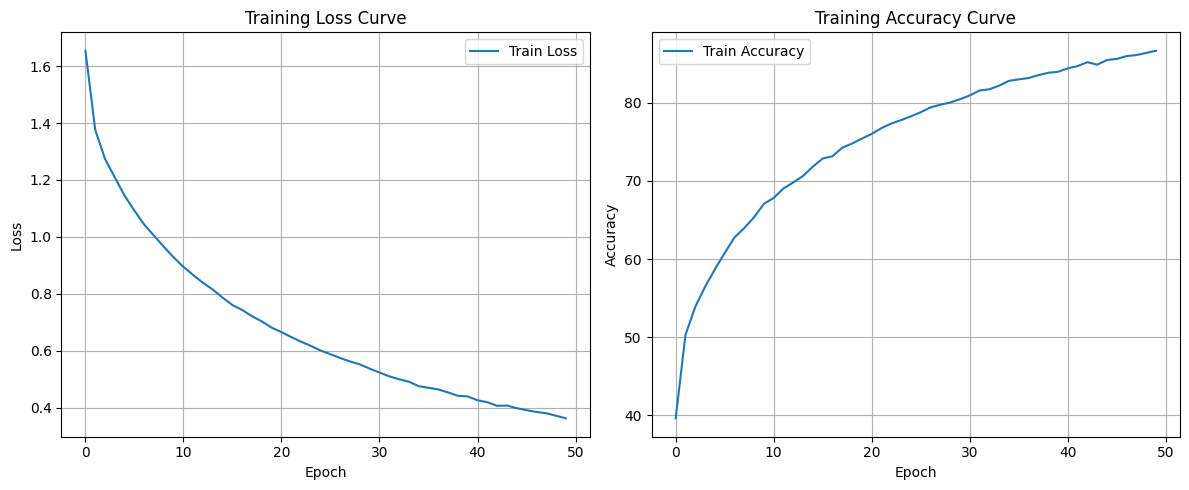


Final Test Loss: 1.1994 | Final Test Accuracy: 67.44%


In [11]:
plot_loss_and_acc(train_losses_emb_dim, train_accuracies_emb_dim)
test_loss_emb_dim, test_acc_emb_dim = evaluate(model_emb_dim, test_loader_param_tuning)
print(f"\nFinal Test Loss: {round(test_loss_emb_dim, 4)} | Final Test Accuracy: {round(test_acc_emb_dim * 100, 2)}%")

### Hyperparameters 2

In [12]:
# Tuneable hyperparameters
emb_dim    = 128
depth      = 6
num_heads  = 4
mlp_ratio  = 2.0
dropout = 0.2

model_depth = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_depth, train_accuracies_depth = train_model(model_depth, lr, epochs, train_loader_param_tuning, device)

Epoch 1/50
Train Loss: 1.6446 | Train Acc: 39.82%

Epoch 2/50
Train Loss: 1.3656 | Train Acc: 50.67%

Epoch 3/50
Train Loss: 1.2638 | Train Acc: 54.31%

Epoch 4/50
Train Loss: 1.1848 | Train Acc: 57.38%

Epoch 5/50
Train Loss: 1.1267 | Train Acc: 59.57%

Epoch 6/50
Train Loss: 1.0727 | Train Acc: 61.59%

Epoch 7/50
Train Loss: 1.0232 | Train Acc: 63.40%

Epoch 8/50
Train Loss: 0.9705 | Train Acc: 65.31%

Epoch 9/50
Train Loss: 0.9297 | Train Acc: 66.85%

Epoch 10/50
Train Loss: 0.8906 | Train Acc: 67.97%

Epoch 11/50
Train Loss: 0.8548 | Train Acc: 69.52%

Epoch 12/50
Train Loss: 0.8234 | Train Acc: 70.38%

Epoch 13/50
Train Loss: 0.7886 | Train Acc: 71.81%

Epoch 14/50
Train Loss: 0.7577 | Train Acc: 72.95%

Epoch 15/50
Train Loss: 0.7373 | Train Acc: 73.69%

Epoch 16/50
Train Loss: 0.7017 | Train Acc: 74.96%

Epoch 17/50
Train Loss: 0.6821 | Train Acc: 75.74%

Epoch 18/50
Train Loss: 0.6560 | Train Acc: 76.56%

Epoch 19/50
Train Loss: 0.6324 | Train Acc: 77.45%

Epoch 20/50
Train Los

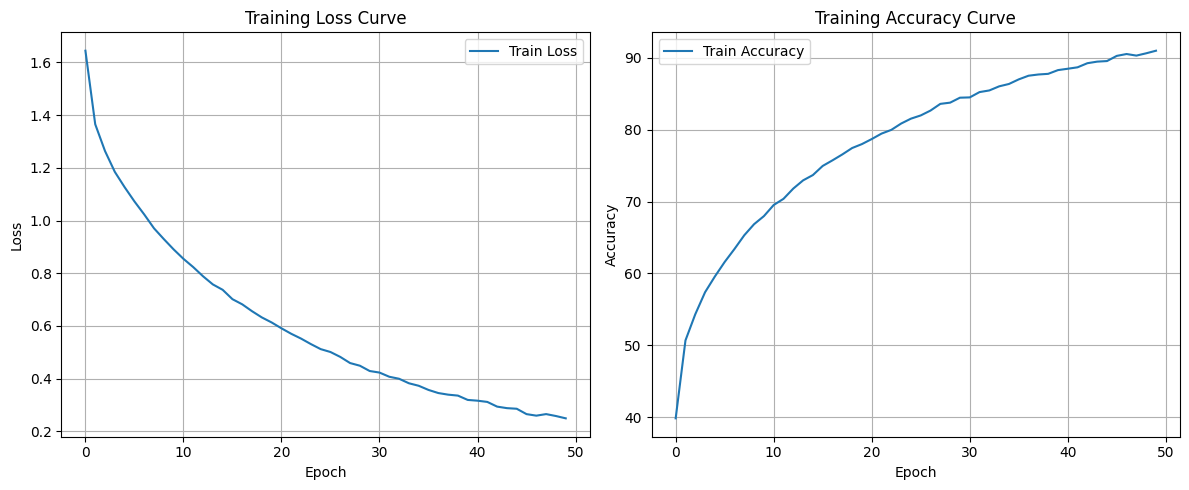


Final Test Loss: 1.2877 | Final Test Accuracy: 69.29%


In [13]:
plot_loss_and_acc(train_losses_depth, train_accuracies_depth)
test_loss_depth, test_acc_depth = evaluate(model_depth, test_loader_param_tuning)
print(f"\nFinal Test Loss: {round(test_loss_depth, 4)} | Final Test Accuracy: {round(test_acc_depth * 100, 2)}%")

### Hyperparameters 3

In [15]:
# Tuneable hyperparameters
emb_dim    = 32
depth      = 6
num_heads  = 4
mlp_ratio  = 2.0
dropout    = 0.1

model_mlp_dim = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_mlp_dim, train_accuracies_mlp_dim = train_model(model_mlp_dim, lr, epochs, train_loader_param_tuning, device)

Epoch 1/50
Train Loss: 1.7771 | Train Acc: 34.65%

Epoch 2/50
Train Loss: 1.4687 | Train Acc: 46.62%

Epoch 3/50
Train Loss: 1.3532 | Train Acc: 51.14%

Epoch 4/50
Train Loss: 1.2803 | Train Acc: 53.69%

Epoch 5/50
Train Loss: 1.2290 | Train Acc: 55.40%

Epoch 6/50
Train Loss: 1.1818 | Train Acc: 57.36%

Epoch 7/50
Train Loss: 1.1451 | Train Acc: 58.76%

Epoch 8/50
Train Loss: 1.1120 | Train Acc: 59.93%

Epoch 9/50
Train Loss: 1.0816 | Train Acc: 61.27%

Epoch 10/50
Train Loss: 1.0490 | Train Acc: 62.25%

Epoch 11/50
Train Loss: 1.0269 | Train Acc: 63.09%

Epoch 12/50
Train Loss: 1.0027 | Train Acc: 64.13%

Epoch 13/50
Train Loss: 0.9869 | Train Acc: 64.57%

Epoch 14/50
Train Loss: 0.9653 | Train Acc: 65.32%

Epoch 15/50
Train Loss: 0.9439 | Train Acc: 66.24%

Epoch 16/50
Train Loss: 0.9275 | Train Acc: 66.89%

Epoch 17/50
Train Loss: 0.9143 | Train Acc: 67.13%

Epoch 18/50
Train Loss: 0.8984 | Train Acc: 67.87%

Epoch 19/50
Train Loss: 0.8842 | Train Acc: 68.28%

Epoch 20/50
Train Los

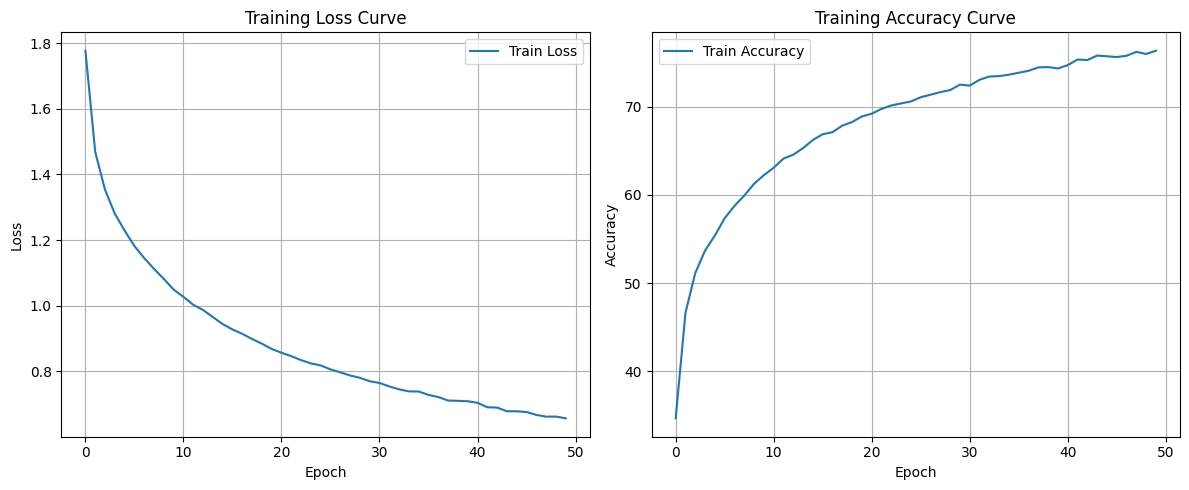


Final Test Loss: 1.0287 | Final Test Accuracy: 65.29%


In [16]:
plot_loss_and_acc(train_losses_mlp_dim, train_accuracies_mlp_dim)
test_loss_mlp_dim, test_acc_mlp_dim = evaluate(model_mlp_dim, test_loader_param_tuning)
print(f"\nFinal Test Loss: {round(test_loss_mlp_dim, 4)} | Final Test Accuracy: {round(test_acc_mlp_dim * 100, 2)}%")

## Data Augmentation

In [ ]:
# Parameters constant throughtout the data augmentation section
patch_size = 4
emb_dim    = 128
depth      = 6
num_heads  = 4
mlp_ratio  = 2.0
epochs     = 50
dropout    = 0.2

### Flip & Rotate

In [ ]:
transform_flip_n_rotate = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5), # 50% chance to flip
    transforms.RandomRotation(10), # Rotate by 10 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset_flip_n_rotate = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform_flip_n_rotate)
test_dataset_flip_n_rotate = CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform_flip_n_rotate)

train_loader_flip_n_rotate = DataLoader(train_dataset_flip_n_rotate, batch_size=batch_size, shuffle=True)
test_loader_flip_n_rotate = DataLoader(test_dataset_flip_n_rotate, batch_size=batch_size, shuffle=False)

In [17]:
model_flip_n_rotate = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_flip_n_rotate, train_accuracies_flip_n_rotate = train_model(model_flip_n_rotate, lr, epochs, train_loader_flip_n_rotate, device)

Epoch 1/50
Train Loss: 1.6332 | Train Acc: 40.55%

Epoch 2/50
Train Loss: 1.3603 | Train Acc: 50.88%

Epoch 3/50
Train Loss: 1.2542 | Train Acc: 54.63%

Epoch 4/50
Train Loss: 1.1841 | Train Acc: 57.34%

Epoch 5/50
Train Loss: 1.1259 | Train Acc: 59.63%

Epoch 6/50
Train Loss: 1.0811 | Train Acc: 61.21%

Epoch 7/50
Train Loss: 1.0371 | Train Acc: 62.90%

Epoch 8/50
Train Loss: 1.0012 | Train Acc: 64.18%

Epoch 9/50
Train Loss: 0.9647 | Train Acc: 65.41%

Epoch 10/50
Train Loss: 0.9297 | Train Acc: 66.69%

Epoch 11/50
Train Loss: 0.8958 | Train Acc: 68.13%

Epoch 12/50
Train Loss: 0.8689 | Train Acc: 68.99%

Epoch 13/50
Train Loss: 0.8426 | Train Acc: 69.92%

Epoch 14/50
Train Loss: 0.8216 | Train Acc: 70.81%

Epoch 15/50
Train Loss: 0.7992 | Train Acc: 71.78%

Epoch 16/50
Train Loss: 0.7773 | Train Acc: 72.52%

Epoch 17/50
Train Loss: 0.7556 | Train Acc: 73.01%

Epoch 18/50
Train Loss: 0.7419 | Train Acc: 73.55%

Epoch 19/50
Train Loss: 0.7248 | Train Acc: 74.14%

Epoch 20/50
Train Los

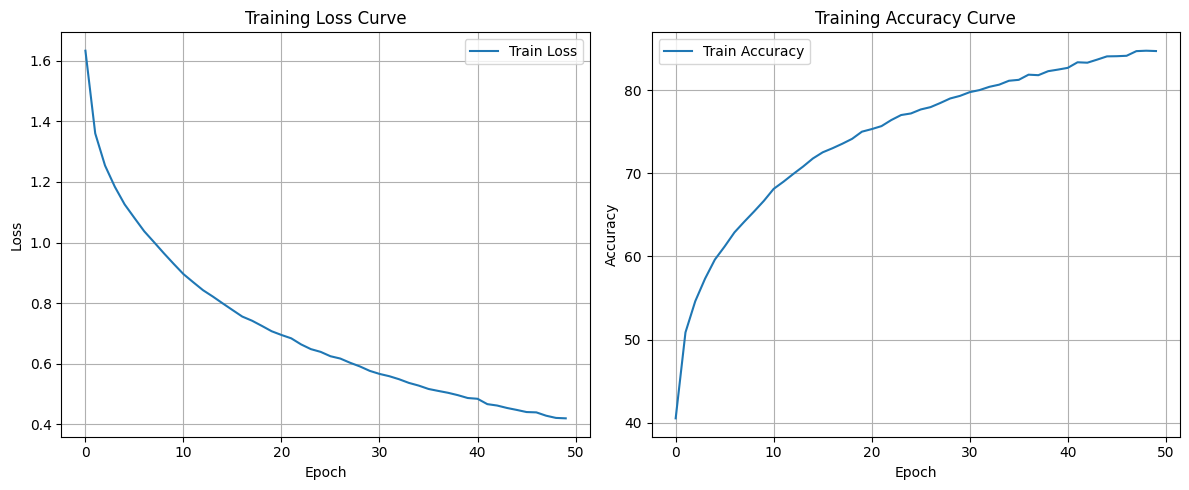


Final Test Loss: 0.849 | Final Test Accuracy: 74.34%


In [19]:
plot_loss_and_acc(train_losses_flip_n_rotate, train_accuracies_flip_n_rotate)
test_loss_flip_n_rotate, test_acc_flip_n_rotate = evaluate(model_flip_n_rotate, test_loader_flip_n_rotate)
print(f"\nFinal Test Loss: {round(test_loss_flip_n_rotate, 4)} | Final Test Accuracy: {round(test_acc_flip_n_rotate * 100, 2)}%")

### Pad and Crop

In [ ]:
transform_pad_n_crop = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset_pad_n_crop = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform_pad_n_crop)
test_dataset_pad_n_crop = CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform_pad_n_crop)

train_loader_pad_n_crop = DataLoader(train_dataset_pad_n_crop, batch_size=batch_size, shuffle=True)
test_loader_pad_n_crop = DataLoader(test_dataset_pad_n_crop, batch_size=batch_size, shuffle=False)

In [20]:
model_pad_n_crop = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_pad_n_crop, train_accuracies_pad_n_crop = train_model(model_pad_n_crop, lr, epochs, train_loader_pad_n_crop, device)

Epoch 1/50
Train Loss: 1.7537 | Train Acc: 35.53%

Epoch 2/50
Train Loss: 1.5172 | Train Acc: 44.83%

Epoch 3/50
Train Loss: 1.4168 | Train Acc: 48.67%

Epoch 4/50
Train Loss: 1.3549 | Train Acc: 50.90%

Epoch 5/50
Train Loss: 1.2977 | Train Acc: 52.80%

Epoch 6/50
Train Loss: 1.2597 | Train Acc: 54.53%

Epoch 7/50
Train Loss: 1.2069 | Train Acc: 56.69%

Epoch 8/50
Train Loss: 1.1648 | Train Acc: 58.04%

Epoch 9/50
Train Loss: 1.1292 | Train Acc: 59.14%

Epoch 10/50
Train Loss: 1.0889 | Train Acc: 61.09%

Epoch 11/50
Train Loss: 1.0560 | Train Acc: 62.09%

Epoch 12/50
Train Loss: 1.0323 | Train Acc: 63.18%

Epoch 13/50
Train Loss: 1.0003 | Train Acc: 64.08%

Epoch 14/50
Train Loss: 0.9699 | Train Acc: 65.53%

Epoch 15/50
Train Loss: 0.9516 | Train Acc: 66.10%

Epoch 16/50
Train Loss: 0.9314 | Train Acc: 66.92%

Epoch 17/50
Train Loss: 0.9130 | Train Acc: 67.47%

Epoch 18/50
Train Loss: 0.8918 | Train Acc: 68.21%

Epoch 19/50
Train Loss: 0.8758 | Train Acc: 68.61%

Epoch 20/50
Train Los

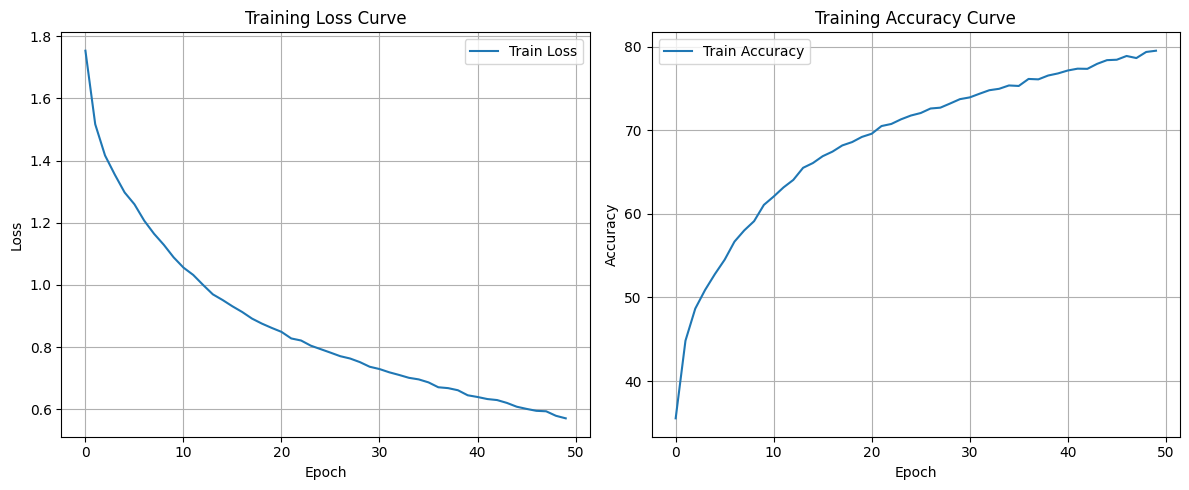


Final Test Loss: 0.6324 | Final Test Accuracy: 78.79%


In [21]:
plot_loss_and_acc(train_losses_pad_n_crop, train_accuracies_pad_n_crop)
test_loss_pad_n_crop, test_acc_pad_n_crop = evaluate(model_pad_n_crop, test_loader_pad_n_crop)
print(f"\nFinal Test Loss: {round(test_loss_pad_n_crop, 4)} | Final Test Accuracy: {round(test_acc_pad_n_crop * 100, 2)}%")

### Auto Augment

In [ ]:
transform_auto = transforms.Compose([
    transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10), # Learns best augmentations from data (more complex)
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset_auto = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform_auto)
test_dataset_auto = CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform_auto)

train_loader_auto = DataLoader(train_dataset_auto, batch_size=batch_size, shuffle=True)
test_loader_auto = DataLoader(test_dataset_auto, batch_size=batch_size, shuffle=False)

In [22]:
model_auto = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_auto, train_accuracies_auto = train_model(model_auto, lr, epochs, train_loader_auto, device)

Epoch 1/50
Train Loss: 1.7782 | Train Acc: 34.62%

Epoch 2/50
Train Loss: 1.5377 | Train Acc: 44.16%

Epoch 3/50
Train Loss: 1.4300 | Train Acc: 48.10%

Epoch 4/50
Train Loss: 1.3556 | Train Acc: 50.76%

Epoch 5/50
Train Loss: 1.2973 | Train Acc: 53.07%

Epoch 6/50
Train Loss: 1.2453 | Train Acc: 54.89%

Epoch 7/50
Train Loss: 1.1931 | Train Acc: 56.96%

Epoch 8/50
Train Loss: 1.1499 | Train Acc: 58.62%

Epoch 9/50
Train Loss: 1.1092 | Train Acc: 60.31%

Epoch 10/50
Train Loss: 1.0643 | Train Acc: 61.99%

Epoch 11/50
Train Loss: 1.0427 | Train Acc: 62.81%

Epoch 12/50
Train Loss: 1.0110 | Train Acc: 63.67%

Epoch 13/50
Train Loss: 0.9818 | Train Acc: 64.92%

Epoch 14/50
Train Loss: 0.9639 | Train Acc: 65.59%

Epoch 15/50
Train Loss: 0.9418 | Train Acc: 66.44%

Epoch 16/50
Train Loss: 0.9157 | Train Acc: 67.32%

Epoch 17/50
Train Loss: 0.9030 | Train Acc: 67.76%

Epoch 18/50
Train Loss: 0.8868 | Train Acc: 68.55%

Epoch 19/50
Train Loss: 0.8689 | Train Acc: 69.15%

Epoch 20/50
Train Los

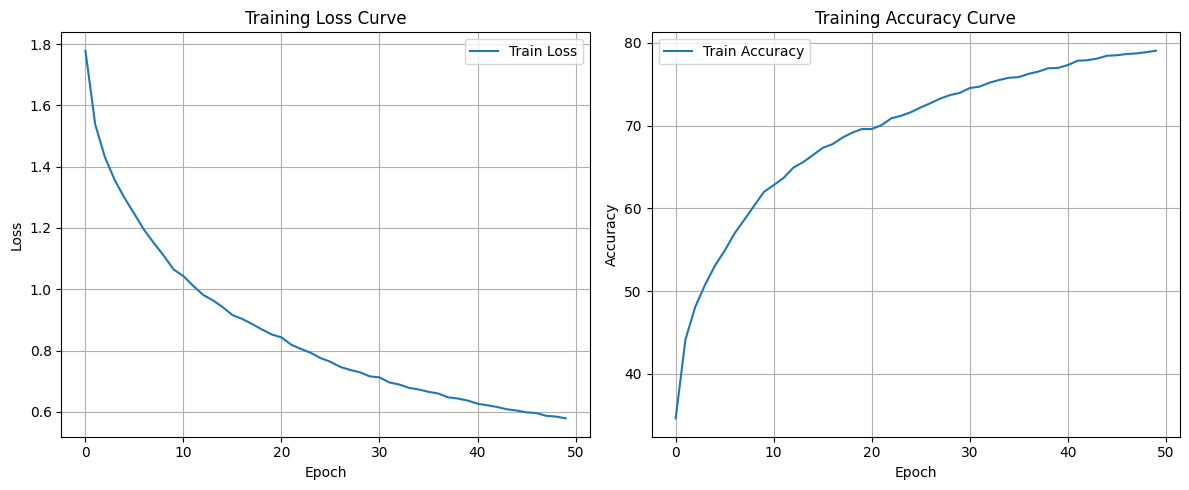


Final Test Loss: 0.5928 | Final Test Accuracy: 79.6%


In [23]:
plot_loss_and_acc(train_losses_auto, train_accuracies_auto)
test_loss_auto, test_acc_auto = evaluate(model_auto, test_loader_auto)
print(f"\nFinal Test Loss: {round(test_loss_auto, 4)} | Final Test Accuracy: {round(test_acc_auto * 100, 2)}%")

## ViT Performance on CIFAR10 with Data Augmentation

### Results:
Below is a comparison of the results after applying different data augmentation techniques:

<table border="1" cellpadding="5">
  <thead>
    <tr>
      <th>Data Augmentation</th>
      <th>Train Loss</th>
      <th>Train Accuracy (%)</th>
      <th>Test Loss</th>
      <th>Test Accuracy (%)</th>
      <th>Training Time (seconds)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Flip and Rotate</td>
      <td>0.4196</td>
      <td>84.69</td>
      <td>0.849</td>
      <td>74.34</td>
      <td>1299.255</td>
    </tr>
    <tr>
      <td>Pad and Crop</td>
      <td>0.5710</td>
      <td>79.55</td>
      <td>0.6324</td>
      <td>78.79</td>
      <td>1278.47</td>
    </tr>
    <tr>
      <td>Auto Augment</td>
      <td>0.5788</td>
      <td>79.36</td>
      <td>0.5928</td>
      <td>79.60</td>
      <td>1322.709</td>
    </tr>
  </tbody>
</table>

### Conclusion:
- **Flip and Rotate** resulted in the highest test accuracy of **74.34%**, indicating that this augmentation strategy helped the model generalize better by increasing the variability of input images, though it had a relatively higher training loss.
- **Pad and Crop** achieved the highest test accuracy of **78.79%** with a reasonable test loss of **0.6324**. This suggests that padding and cropping effectively augmented the data while preserving important spatial features.
- **Auto Augment** yielded the highest test accuracy of **79.60%**, with the lowest test loss of **0.5928**, making it the best augmentation strategy in terms of test performance, although it required the most training time.

In conclusion, **Auto Augment** was the most effective augmentation technique, as it produced the best test accuracy and lowest test loss, despite the slightly higher training time. In Auto Augment it learns the augmentation based on the data and hence is more complex (leading to more time).

## Positional Embeddings Experimentation

In [ ]:
# Parameters constant throughtout the positional embeddings experimentation section
patch_size = 4
emb_dim    = 128
depth      = 4
num_heads  = 4
mlp_ratio  = 2.0

transform_pos_emb = transforms.Compose([
    transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10), # Learns best augmentations from data (more complex)
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset_pos_emb = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform_pos_emb)
test_dataset_pos_emb = CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform_pos_emb)

train_loader_pos_emb = DataLoader(train_dataset_pos_emb, batch_size=batch_size, shuffle=True)
test_loader_pos_emb = DataLoader(test_dataset_pos_emb, batch_size=batch_size, shuffle=False)

### No positional embeddings

In [24]:
model_no_pos_emb = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout, positional_embeddings = None)
train_losses_no_pos_emb, train_accuracies_no_pos_emb = train_model(model_no_pos_emb, lr, epochs, train_loader_pos_emb, device)

Epoch 1/50
Train Loss: 1.7945 | Train Acc: 32.80%

Epoch 2/50
Train Loss: 1.5775 | Train Acc: 42.00%

Epoch 3/50
Train Loss: 1.4774 | Train Acc: 45.87%

Epoch 4/50
Train Loss: 1.4087 | Train Acc: 48.81%

Epoch 5/50
Train Loss: 1.3647 | Train Acc: 50.35%

Epoch 6/50
Train Loss: 1.3225 | Train Acc: 52.00%

Epoch 7/50
Train Loss: 1.2868 | Train Acc: 53.49%

Epoch 8/50
Train Loss: 1.2572 | Train Acc: 54.49%

Epoch 9/50
Train Loss: 1.2340 | Train Acc: 55.43%

Epoch 10/50
Train Loss: 1.2101 | Train Acc: 56.16%

Epoch 11/50
Train Loss: 1.1855 | Train Acc: 57.30%

Epoch 12/50
Train Loss: 1.1640 | Train Acc: 57.97%

Epoch 13/50
Train Loss: 1.1454 | Train Acc: 58.72%

Epoch 14/50
Train Loss: 1.1266 | Train Acc: 59.59%

Epoch 15/50
Train Loss: 1.1079 | Train Acc: 60.19%

Epoch 16/50
Train Loss: 1.0922 | Train Acc: 60.95%

Epoch 17/50
Train Loss: 1.0695 | Train Acc: 61.53%

Epoch 18/50
Train Loss: 1.0621 | Train Acc: 61.80%

Epoch 19/50
Train Loss: 1.0426 | Train Acc: 62.68%

Epoch 20/50
Train Los

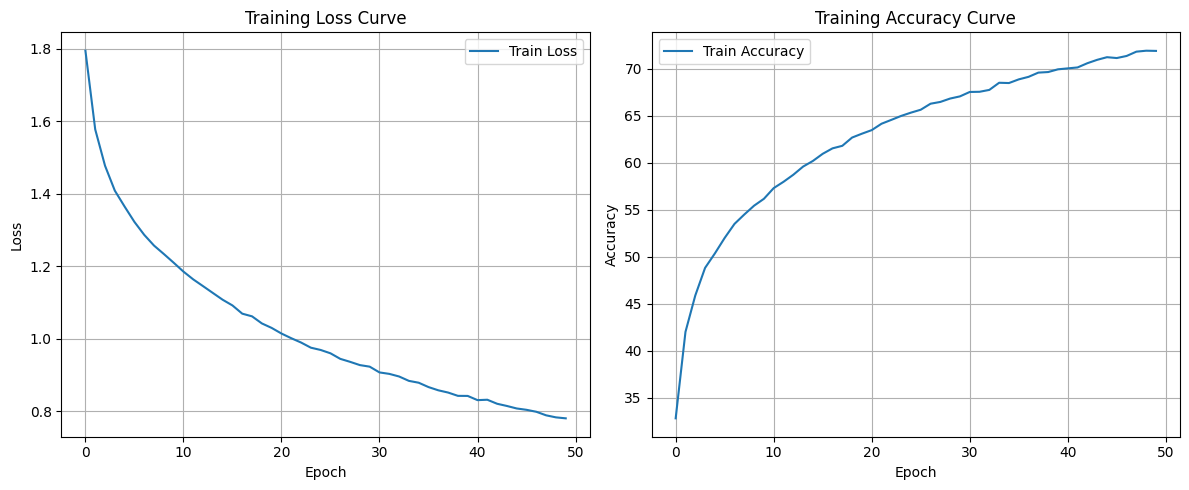


Final Test Loss: 0.8495 | Final Test Accuracy: 70.81%


In [25]:
plot_loss_and_acc(train_losses_no_pos_emb, train_accuracies_no_pos_emb)
test_loss_no_pos_emb, test_acc_no_pos_emb = evaluate(model_no_pos_emb, test_loader_pos_emb)
print(f"\nFinal Test Loss: {round(test_loss_no_pos_emb, 4)} | Final Test Accuracy: {round(test_acc_no_pos_emb * 100, 2)}%")

### 1D learned embeddings

> Ran Above (Initial Model)

### 2D learned embeddings

In [26]:
model_2d_emb = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout, positional_embeddings = "2d")
train_losses_2d_emb, train_accuracies_2d_emb = train_model(model_2d_emb, lr, epochs, train_loader_pos_emb, device)

Epoch 1/50
Train Loss: 1.7141 | Train Acc: 36.98%

Epoch 2/50
Train Loss: 1.4614 | Train Acc: 46.71%

Epoch 3/50
Train Loss: 1.3674 | Train Acc: 50.13%

Epoch 4/50
Train Loss: 1.3091 | Train Acc: 52.69%

Epoch 5/50
Train Loss: 1.2658 | Train Acc: 54.18%

Epoch 6/50
Train Loss: 1.2272 | Train Acc: 55.60%

Epoch 7/50
Train Loss: 1.1837 | Train Acc: 57.19%

Epoch 8/50
Train Loss: 1.1469 | Train Acc: 58.78%

Epoch 9/50
Train Loss: 1.1038 | Train Acc: 60.31%

Epoch 10/50
Train Loss: 1.0734 | Train Acc: 61.58%

Epoch 11/50
Train Loss: 1.0481 | Train Acc: 62.25%

Epoch 12/50
Train Loss: 1.0112 | Train Acc: 63.90%

Epoch 13/50
Train Loss: 0.9823 | Train Acc: 64.98%

Epoch 14/50
Train Loss: 0.9571 | Train Acc: 65.79%

Epoch 15/50
Train Loss: 0.9361 | Train Acc: 66.64%

Epoch 16/50
Train Loss: 0.9193 | Train Acc: 67.15%

Epoch 17/50
Train Loss: 0.9062 | Train Acc: 67.56%

Epoch 18/50
Train Loss: 0.8821 | Train Acc: 68.43%

Epoch 19/50
Train Loss: 0.8677 | Train Acc: 69.13%

Epoch 20/50
Train Los

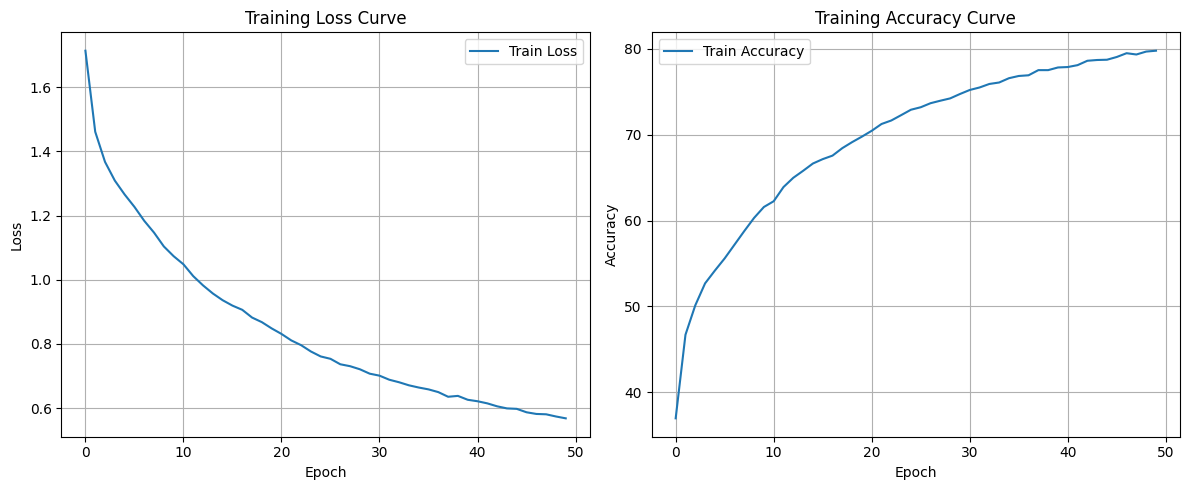


Final Test Loss: 0.6388 | Final Test Accuracy: 78.47%


In [27]:
plot_loss_and_acc(train_losses_2d_emb, train_accuracies_2d_emb)
test_loss_2d_emb, test_acc_2d_emb = evaluate(model_2d_emb, test_loader_pos_emb)
print(f"\nFinal Test Loss: {round(test_loss_2d_emb, 4)} | Final Test Accuracy: {round(test_acc_2d_emb * 100, 2)}%")

### Sinusoidal embeddings

In [28]:
model_sin_emb = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout, positional_embeddings = "sinusoidal")
train_losses_sin_emb, train_accuracies_sin_emb = train_model(model_sin_emb, lr, epochs, train_loader_pos_emb, device)

Epoch 1/50
Train Loss: 1.7011 | Train Acc: 37.10%

Epoch 2/50
Train Loss: 1.4330 | Train Acc: 47.90%

Epoch 3/50
Train Loss: 1.3376 | Train Acc: 51.44%

Epoch 4/50
Train Loss: 1.2717 | Train Acc: 53.76%

Epoch 5/50
Train Loss: 1.2163 | Train Acc: 55.91%

Epoch 6/50
Train Loss: 1.1722 | Train Acc: 57.86%

Epoch 7/50
Train Loss: 1.1320 | Train Acc: 59.30%

Epoch 8/50
Train Loss: 1.0943 | Train Acc: 60.47%

Epoch 9/50
Train Loss: 1.0641 | Train Acc: 62.00%

Epoch 10/50
Train Loss: 1.0344 | Train Acc: 63.00%

Epoch 11/50
Train Loss: 1.0075 | Train Acc: 64.00%

Epoch 12/50
Train Loss: 0.9801 | Train Acc: 64.99%

Epoch 13/50
Train Loss: 0.9587 | Train Acc: 65.74%

Epoch 14/50
Train Loss: 0.9381 | Train Acc: 66.44%

Epoch 15/50
Train Loss: 0.9114 | Train Acc: 67.38%

Epoch 16/50
Train Loss: 0.8936 | Train Acc: 68.07%

Epoch 17/50
Train Loss: 0.8746 | Train Acc: 68.93%

Epoch 18/50
Train Loss: 0.8543 | Train Acc: 69.69%

Epoch 19/50
Train Loss: 0.8392 | Train Acc: 70.41%

Epoch 20/50
Train Los

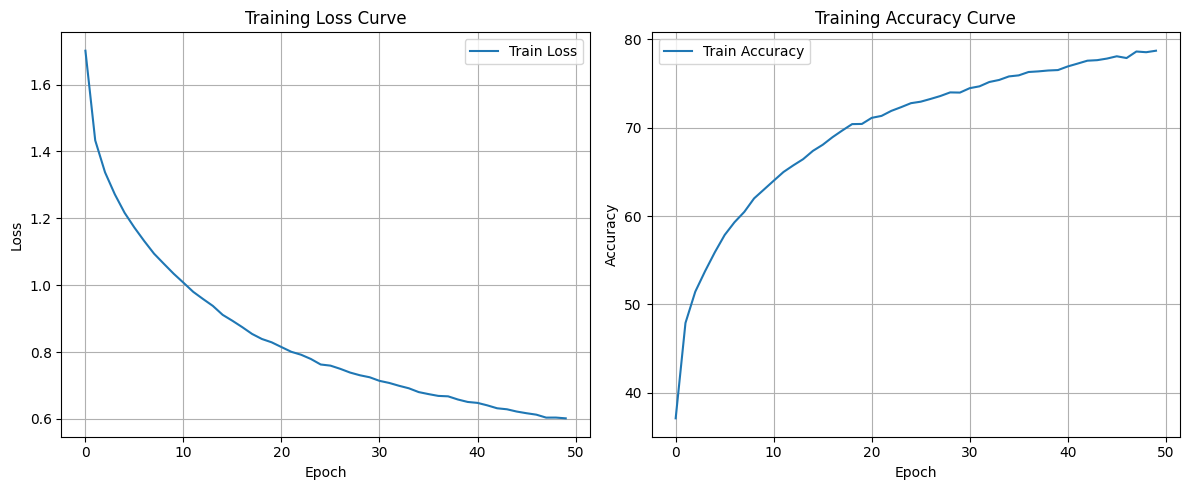


Final Test Loss: 0.6394 | Final Test Accuracy: 78.36%


In [29]:
plot_loss_and_acc(train_losses_sin_emb, train_accuracies_sin_emb)
test_loss_sin_emb, test_acc_sin_emb = evaluate(model_sin_emb, test_loader_pos_emb)
print(f"\nFinal Test Loss: {round(test_loss_sin_emb, 4)} | Final Test Accuracy: {round(test_acc_sin_emb * 100, 2)}%")

## ViT Performance on CIFAR10 with Various Positional Embeddings

### Results:
Below is a comparison of the results with different positional embeddings:

<table border="1" cellpadding="5">
  <thead>
    <tr>
      <th>Positional Embedding</th>
      <th>Train Loss</th>
      <th>Train Accuracy (%)</th>
      <th>Test Loss</th>
      <th>Test Accuracy (%)</th>
      <th>Training Time (seconds)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>No Embedding</td>
      <td>0.7809</td>
      <td>71.90</td>
      <td>0.8495</td>
      <td>70.81</td>
      <td>1201.238</td>
    </tr>
    <tr>
      <td>1D Embedding</td>
      <td>0.3035</td>
      <td>78.91</td>
      <td>0.6412</td>
      <td>76.92</td>
      <td>1289.707</td>
    </tr>
    <tr>
      <td>2D Embedding</td>
      <td>0.5678</td>
      <td>79.77</td>
      <td>0.6388</td>
      <td>78.47</td>
      <td>1321.113</td>
    </tr>
    <tr>
      <td>Sinusoidal Embedding</td>
      <td>0.6019</td>
      <td>78.72</td>
      <td>0.6394</td>
      <td>78.36</td>
      <td>1398.264</td>
    </tr>
  </tbody>
</table>

### Conclusion:
The performance of 1D Embedding and 2D Embedding is quite similar, with 1D Embedding achieving a test accuracy of 76.92% and 2D Embedding achieving 78.47%. However, since 1D Embedding is simpler and requires less computational time (1289.707 seconds compared to 1321.113 seconds for 2D), it is preferred for tasks where computational efficiency is important. While Sinusoidal Embedding performs similarly to 2D embedding, it has the longest training time, making it less favorable. Overall, 1D Embedding strikes a good balance between performance and efficiency, offering a competitive test accuracy with lower time costs.


## DINO Attention Maps

### 1st Image - Airplane (From CIFAR10)

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall8_300ep_pretrain.pth
100%|███████████████████████████████████████| 82.7M/82.7M [00:00<00:00, 164MB/s]
./attn-head0.png saved.
./attn-head1.png saved.
./attn-head2.png saved.
./attn-head3.png saved.
./attn-head4.png saved.
./attn-head5.png saved.


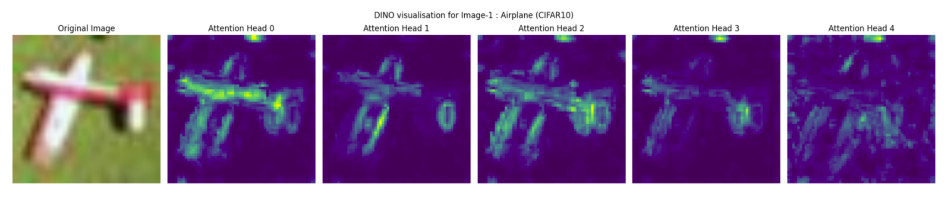

In [37]:
# Generating the heatmaps
!python /kaggle/input/dino-code2/dino/visualize_attention.py --image_path /kaggle/input/sample-images-to-visualise2/images-v3/airplane.jpg

# Plotting the output
fig, axes = plt.subplots(1, 6, figsize=(20, 4))

for i in range(6):
    if i == 0:
        img = cv2.imread("/kaggle/working/img.png")
        axes[i].set_title("Original Image")
    else:
        img = cv2.imread(f"/kaggle/working/attn-head{i - 1}.png")
        axes[i].set_title(f"Attention Head {i - 1}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.suptitle(f"DINO visualisation for Image-1 : Airplane (CIFAR10)")
plt.tight_layout()
plt.show()

### 2nd Image - Ship (CIFAR10)

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
./attn-head0.png saved.
./attn-head1.png saved.
./attn-head2.png saved.
./attn-head3.png saved.
./attn-head4.png saved.
./attn-head5.png saved..


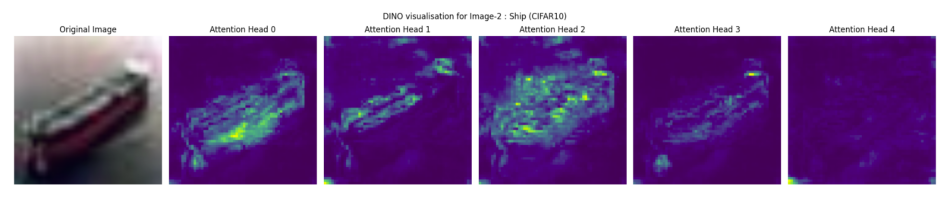

In [38]:
# Generating the heatmaps
!python /kaggle/input/dino-code2/dino/visualize_attention.py --image_path /kaggle/input/sample-images-to-visualise2/images-v3/ship.jpg

# Plotting the output
fig, axes = plt.subplots(1, 6, figsize=(20, 4))

for i in range(6):
    if i == 0:
        img = cv2.imread("/kaggle/working/img.png")
        axes[i].set_title("Original Image")
    else:
        img = cv2.imread(f"/kaggle/working/attn-head{i - 1}.png")
        axes[i].set_title(f"Attention Head {i - 1}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.suptitle(f"DINO visualisation for Image-2 : Ship (CIFAR10)")
plt.tight_layout()
plt.show()

## ViT CIFAR-10 Attention Maps

For Image 1


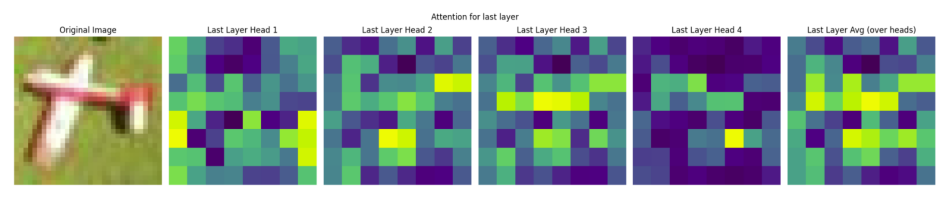

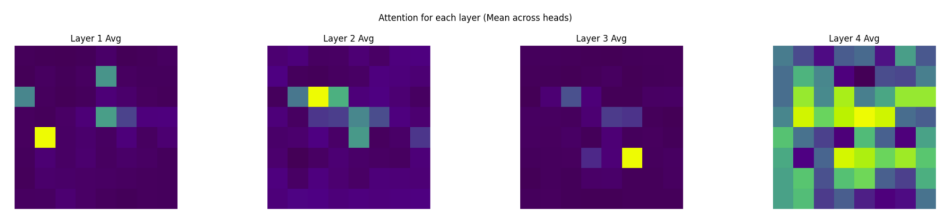

For Image 2


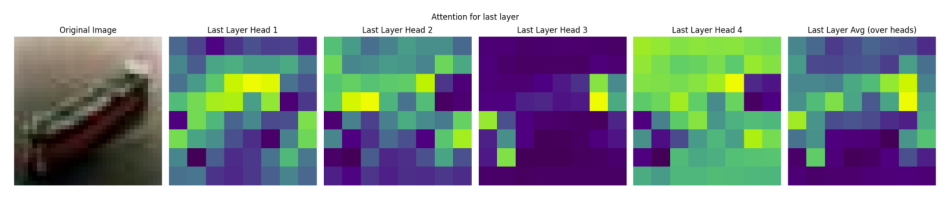

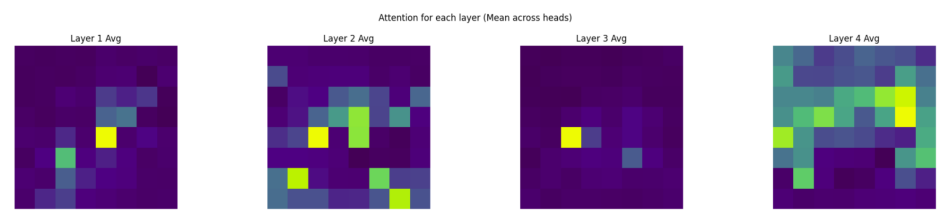

In [39]:
from PIL import Image
img1 = Image.open("/kaggle/input/sample-images-to-visualise2/images-v3/airplane.jpg").convert("RGB")
img2 = Image.open("/kaggle/input/sample-images-to-visualise2/images-v3/ship.jpg").convert("RGB")

imgs = [img1, img2]

transform_vis = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

img1_tensor = transform_vis(img1)  # [3, 32, 32]
img2_tensor = transform_vis(img2)  # [3, 32, 32]

# Patching function
def img_to_patches(img, patch_size=4):
    C, H, W = img.shape
    patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.permute(1, 2, 0, 3, 4).contiguous()  # [num_patches_H, num_patches_W, C, p, p]
    patches = patches.view(-1, C * patch_size * patch_size)  # [num_patches, patch_dim]
    return patches

# Apply patching
patch_size = 4
patches1 = img_to_patches(img1_tensor, patch_size=patch_size)  # [64, 48]
patches2 = img_to_patches(img2_tensor, patch_size=patch_size)  # [64, 48]

# Create a batch of patch sequences
images = torch.stack([patches1, patches2])  # [2, 64, 48]  # shape: [2, 3, 32, 32]

def get_maps(model, img, device):
    final_output = []

    org_img = img.clone()
    final_output.append((org_img, "Original Image"))

    img = img.to(device)
    _ = model(img.unsqueeze(0))  # Forward pass (returns ignored if needed)
    
    attn_weights = model.transformer.attn_weights  # List of tensors: [L][1, H, T, T]

    last_layer_attn = attn_weights[-1]
    num_heads = last_layer_attn.shape[1]
    num_layers = len(attn_weights)

    # Get [CLS] to all patch tokens (ignore [CLS] itself at index 0)
    grid_size = int((last_layer_attn.shape[-1] - 1) ** 0.5)

    # Head-wise attention from last layer
    for head_idx in range(num_heads):
        cls_attn = last_layer_attn[0, head_idx, 0, 1:]  # [patches]
        attn_map = cls_attn.reshape(grid_size, grid_size).detach().cpu().numpy()
        final_output.append((attn_map, f"Last Layer Head {head_idx + 1}"))

    # Aggregated attention across heads in last layer
    cls_attn_avg = last_layer_attn[0, :, 0, 1:].mean(dim=0)
    attn_map_avg = cls_attn_avg.reshape(grid_size, grid_size).detach().cpu().numpy()
    final_output.append((attn_map_avg, "Last Layer Avg (over heads)"))

    final_output2 = []

    # Attention from all layers (aggregated over heads)
    for layer_idx in range(num_layers):
        layer_attn = attn_weights[layer_idx]
        cls_attn = layer_attn[0, :, 0, 1:].mean(dim=0)  # mean over heads
        attn_map = cls_attn.reshape(grid_size, grid_size).detach().cpu().numpy()
        final_output2.append((attn_map, f"Layer {layer_idx + 1} Avg"))

    return final_output, final_output2

for img_idx, img in enumerate(images):
    print(f"For image {img_idx + 1}")
    last_layer_maps, layer_wise_maps = get_maps(model_initial, img, device)
    
    fig, axes = plt.subplots(1, len(last_layer_maps), figsize=(20, 4))
    for i in range(len(last_layer_maps)):
        if i == 0:
            axes[i].imshow(imgs[img_idx])
            axes[i].set_title("Original Image")
        else:
            axes[i].imshow(last_layer_maps[i][0])
            axes[i].set_title(last_layer_maps[i][1])
        axes[i].axis('off')
    plt.suptitle("Attention for last layer")
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, len(layer_wise_maps), figsize=(20, 4))
    for i in range(len(layer_wise_maps)):
        axes[i].imshow(layer_wise_maps[i][0])
        axes[i].set_title(layer_wise_maps[i][1])
        axes[i].axis('off')
    plt.suptitle("Attention for each layer (Mean across heads)")
    plt.tight_layout()
    plt.show()

## Attention Rollout

For Image 1


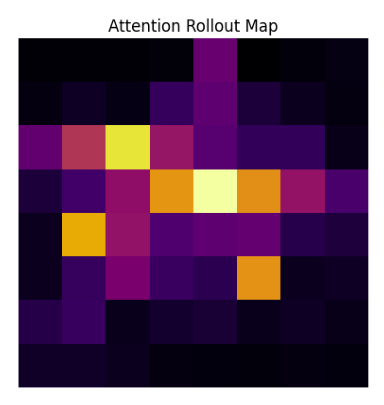

For Image 2


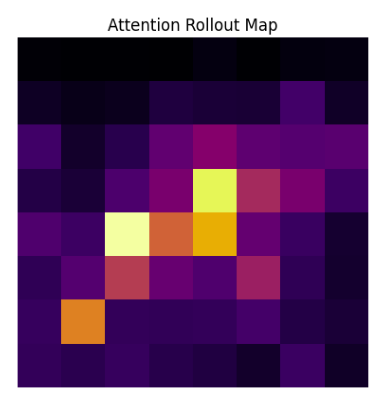

In [40]:
def compute_attention_rollout(attn_weights, add_residual=True):
    num_layers = len(attn_weights)
    batch_size, num_heads, T, _ = attn_weights[0].shape
    device = attn_weights[0].device

    # Start with identity
    rollout = torch.eye(T, device=device).unsqueeze(0).repeat(batch_size, 1, 1)  # [1, T, T]

    for layer_attn in attn_weights:
        # shape: [1, H, T, T]
        attn_mean = layer_attn.mean(dim=1)  # Mean over heads → [1, T, T]
        
        if add_residual:
            attn_mean += torch.eye(T, device=device).unsqueeze(0)  # Add identity
            attn_mean /= attn_mean.sum(dim=-1, keepdim=True)       # Normalize rows

        rollout = attn_mean @ rollout  # Matrix multiply each step

    return rollout.squeeze(0)  # Final shape: [T, T]

for img_idx, img in enumerate(images):
    print(f"For Image {img_idx + 1}")
    org_img = img.clone()
    img = img.to(device)
    _ = model_initial(img.unsqueeze(0))  # Forward pass (returns ignored if needed)
    
    attn_weights = model_initial.transformer.attn_weights  # List of tensors: [L][1, H, T, T]
    last_layer_attn = attn_weights[-1]
    rollout_attn = compute_attention_rollout(attn_weights)  # [T, T]
    cls_to_patches = rollout_attn[0, 1:]  # CLS attends to patch tokens

    # Visualize (assuming square patch layout)
    num_patches = int((cls_to_patches.shape[0]) ** 0.5)
    heatmap = cls_to_patches.reshape(num_patches, num_patches).detach().cpu().numpy()
    
    # Optional: upscale to original image resolution
    grid_size = int((last_layer_attn.shape[-1] - 1) ** 0.5)
    heatmap = cv2.resize(heatmap, (grid_size, grid_size))  # (H, W)
    plt.imshow(heatmap, cmap='inferno')
    plt.axis('off')
    plt.title("Attention Rollout Map")
    plt.show()

## Positional Embeddings Visualisation

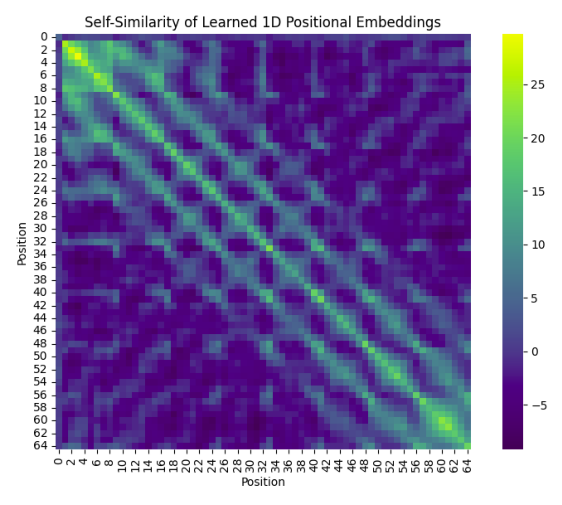

In [41]:
pos_emb = model_initial.pos_embed.squeeze(0).detach().cpu()
similarity = pos_emb @ pos_emb.T

plt.figure(figsize=(8, 6))
sns.heatmap(similarity.numpy(), cmap='viridis', square=True)
plt.title("Self-Similarity of Learned 1D Positional Embeddings")
plt.xlabel("Position")
plt.ylabel("Position")
plt.tight_layout()
plt.show()

## Overall Summary

### Summary for Normal Vision Transformer (ViT) on CIFAR10:

The Vision Transformer (ViT) was trained on the CIFAR10 dataset with various configurations of patch sizes, positional embeddings, and data augmentation techniques. The patch size ablation showed that smaller patch sizes (such as 2) provide finer details but increase training time, while larger patches (such as 8) result in coarser representations and lower test accuracy. Among positional embeddings, 1D embedding was found to be the most efficient, offering a balance of performance and lower training time compared to 2D and sinusoidal embeddings. Data augmentation techniques like Pad and Crop improved generalization and resulted in the highest test accuracy of 78.79%. Overall, 1D positional embedding and Pad and Crop augmentation were the most effective strategies for improving ViT performance.